In [1]:
import json
import pandas as pd
import PIL
from PIL import ImageDraw
import requests
from io import BytesIO
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def urls_to_images(urls):
    images = []
    for i in urls:
        try:
            response = requests.get(i)
            images.append((PIL.Image.open(BytesIO(response.content)).convert('RGB')))
        except Exception as ex:
            print(f'not load {i}')
            print(ex)
    return images

In [3]:
urls = ['https://avatars.mds.yandex.net/get-marketpic/8674002/picc5f994be2d76aed732d424752291e251/orig',
 'https://avatars.mds.yandex.net/get-marketpic/5581373/picd9a621163755cd9f53e26949f82d1470/orig',
 'https://avatars.mds.yandex.net/get-marketpic/8332475/pic5309151fa023e4a546fd1bdec4be5aed/orig',
 'https://avatars.mds.yandex.net/get-marketpic/1847713/pic8c65785b18626b796e576f1c0c9baa99/orig']+['https://lead-assessors.s3.yandex.net/8794f117-98d8-494e-90d7-cbc2cedfa167', 'https://avatars.mds.yandex.net/get-marketpic/5490816/pic95a683279e16a85f530be15e4fdc5d45/orig', 'https://avatars.mds.yandex.net/get-marketpic/7763293/pic583483979489e6ef1dcb972798e53ab6/orig']

In [4]:
images = urls_to_images(urls)

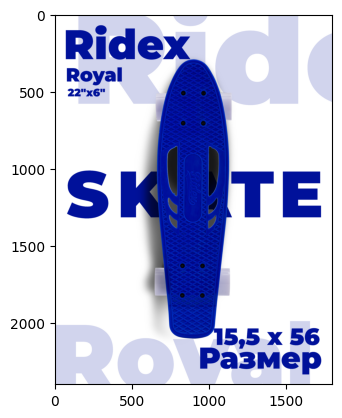

In [5]:
k = 1
plt.imshow(images[k])

## text detection

In [51]:
import easyocr
reader = easyocr.Reader(['ru','en'])

In [6]:
open_cv_image = np.array(images[k].copy()) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy()

In [ ]:
plt.imshow(open_cv_image)

In [8]:
image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(image)

In [ ]:
bounds = reader.readtext(image) #CV2
bounds

[([[67, 61], [791, 61], [791, 171], [67, 171]],
  'КОКОСОВАЯ',
  0.9907305072958831),
 ([[68, 180], [650, 180], [650, 282], [68, 282]],
  'ОБСЫПКА',
  0.9998715401815483),
 ([[73, 299], [740, 299], [740, 348], [73, 348]],
  'Вместо сахарной пудры наш мармелад',
  0.9746237749508435),
 ([[75, 344], [631, 344], [631, 388], [75, 388]],
  'обсыпается кокосовой стружкой;',
  0.9037513065645304),
 ([[76, 392], [377, 392], [377, 420], [76, 420]],
  'чтО позволяетнам',
  0.7655750909080914),
 ([[380, 385], [573, 385], [573, 427], [380, 427]],
  'уменьшить',
  0.9999734558887118),
 ([[75, 428], [736, 428], [736, 472], [75, 472]],
  'количество простых сахаров в составе;',
  0.9331752143458639),
 ([[75, 475], [371, 475], [371, 511], [75, 511]],
  'a также получить',
  0.9647367813539205),
 ([[370, 470], [663, 470], [663, 515], [370, 515]],
  'интересный вкус',
  0.9834597760174713),
 ([[76, 520], [100, 520], [100, 544], [76, 544]], 'И', 0.8899783040831757),
 ([[103, 517], [425, 517], [425, 555],

In [10]:
def bb_intersection(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    # print(interArea)
    if interArea <= 1:
        return 0
    else:
        return interArea

In [67]:

def draw_boxes(img, bounds, color='yellow', width=2):
    image = img.copy()
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
        # draw.rectangle((408, 608, 436, 642), fill=(0, 192, 192), outline=(255, 255, 255))
    return image


In [12]:
#Draw bounding boxes PIL
image_draw = PIL.Image.fromarray(image)
i = draw_boxes(image_draw, bounds)

NameError: name 'bounds' is not defined

In [13]:
i

NameError: name 'i' is not defined

## dataset

In [44]:
d = {'all':[]}
with open("/home/yagor/Рабочий стол/yandex generation/load data/pictures_market.txt") as infile:
    for line in infile:
        result = json.loads(line)
        d['all'].append(result)
df = pd.DataFrame(d['all'])
df.head(3)

market_sku_id                                            pic_url  \
0     1402035435  //avatars.mds.yandex.net/get-marketpic/7044394...   
1     1402035435  //avatars.mds.yandex.net/get-marketpic/5620596...   
2     1402035435  //avatars.mds.yandex.net/get-marketpic/1708436...   

                       verdict  
0  clean_photo_good_background  
1  clean_photo_good_background  
2           other_infographics

## models

### GroundedDINO

In [ ]:
# %cd {HOME}/GroundingDINO
# !pip install -q -e .

In [ ]:
# cd ..

In [10]:
import supervision as sv
import os
HOME = os.getcwd()
print("HOME:", HOME)
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

HOME: /home/yagor/Рабочий стол/yandex generation/load data
/home/yagor/Рабочий стол/yandex generation/load data/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/home/yagor/Рабочий стол/yandex generation/load data/weights/groundingdino_swint_ogc.pth ; exist: True


In [11]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/home/yagor/Рабочий стол/yandex generation/load data/GroundingDINO


/home/yagor/anaconda3/envs/detect/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [13]:
CLASSES = ['product', 'packaging', 'furniture', 'device'] #  'device' 'thing', 'spare parts' 'device'
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.25

### SAM

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [15]:
import sys
%cd {HOME}
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);
sam_predictor = SamPredictor(sam)

/home/yagor/Рабочий стол/yandex generation/load data


In [16]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

/home/yagor/anaconda3/envs/detect/lib/python3.10/site-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/yagor/anaconda3/envs/detect/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


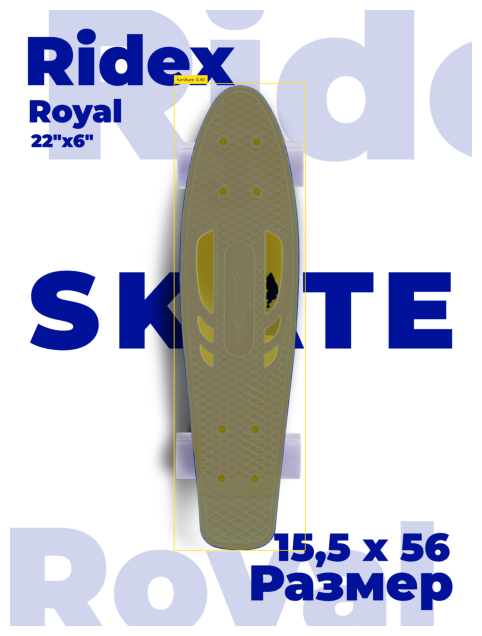

In [17]:
import cv2
import supervision as sv

from typing import List


def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]
# load image
image = open_cv_image.copy()#cv2.imread(SOURCE_IMAGE_PATH)
# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)
best_confidence = np.max(detections.confidence)
# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
detections = detections[detections.class_id != None]
detections = detections[detections.confidence==best_confidence]

    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.show()
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
%matplotlib inline
sv.plot_image(annotated_image, (8, 8))

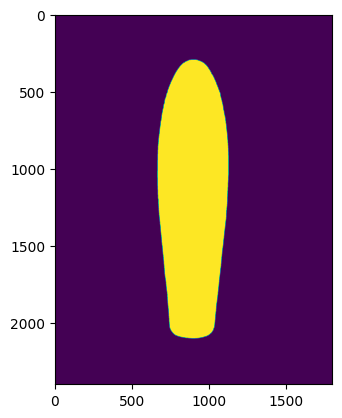

In [18]:
from skimage import morphology
b = morphology.remove_small_holes(detections.mask[0], image.shape[0]*image.shape[1]/10)
gray_mask = b.astype(np.uint8)*255
plt.imshow(gray_mask)

In [19]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [20]:
import torch
from diffusers import StableDiffusionXLInpaintPipeline
from diffusers.utils import load_image

pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True)
pipe.enable_model_cpu_offload()



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [77]:
# pipe.to("cuda")
image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB)
pil_mask = PIL.Image.fromarray(gray_mask)
invert_mask = PIL.ImageOps.invert(pil_mask).convert("RGB")
pil_image = PIL.Image.fromarray(image.copy()).convert("RGB")


In [22]:
h = 1024
height, width = h, h

In [23]:
mask_image = invert_mask.resize((height, width ))
image2sdx =  pil_image.resize((height, width ))

In [40]:
import gc
torch.cuda.empty_cache()
gc.collect()

1150

In [ ]:
del sam_predictor

In [75]:
prompt = 'ocean water and waves in excellent 4k quality' #'beautiful red flowers in a pot with a grey background good quality'
negative_prompt = 'bad quality many text'
guidance_scale = 7.5
#height, width = 512, 512#pil_image.size
strength = 0.99
num_images_per_prompt = 1
image = pipe(prompt=prompt, negative_prompt=negative_prompt, strength=strength, guidance_scale=guidance_scale, num_images_per_prompt=num_images_per_prompt, height=height, width=width, image=image2sdx, mask_image=mask_image, num_inference_steps=80).images

  0%|          | 0/79 [00:00<?, ?it/s]

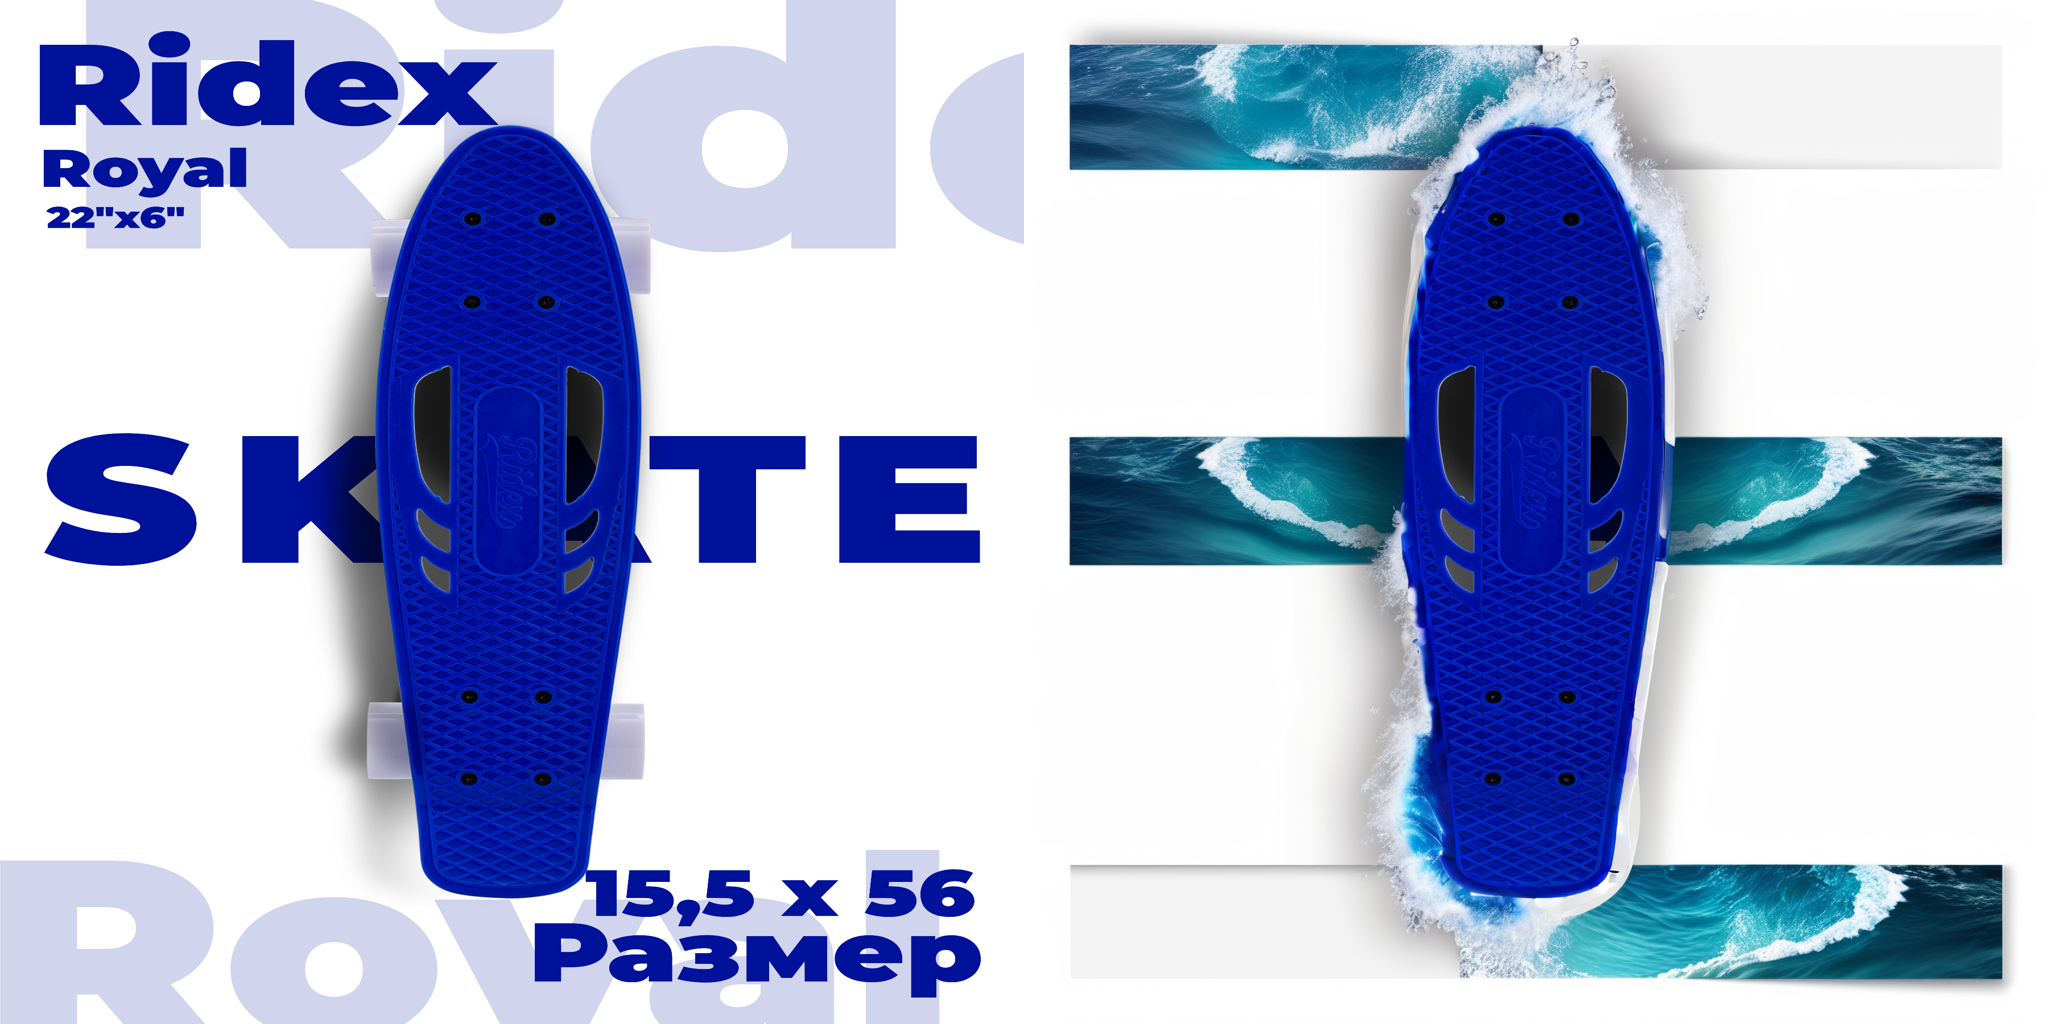

In [76]:
image.insert(0, image2sdx)

image_grid(image, 1, num_images_per_prompt + 1)

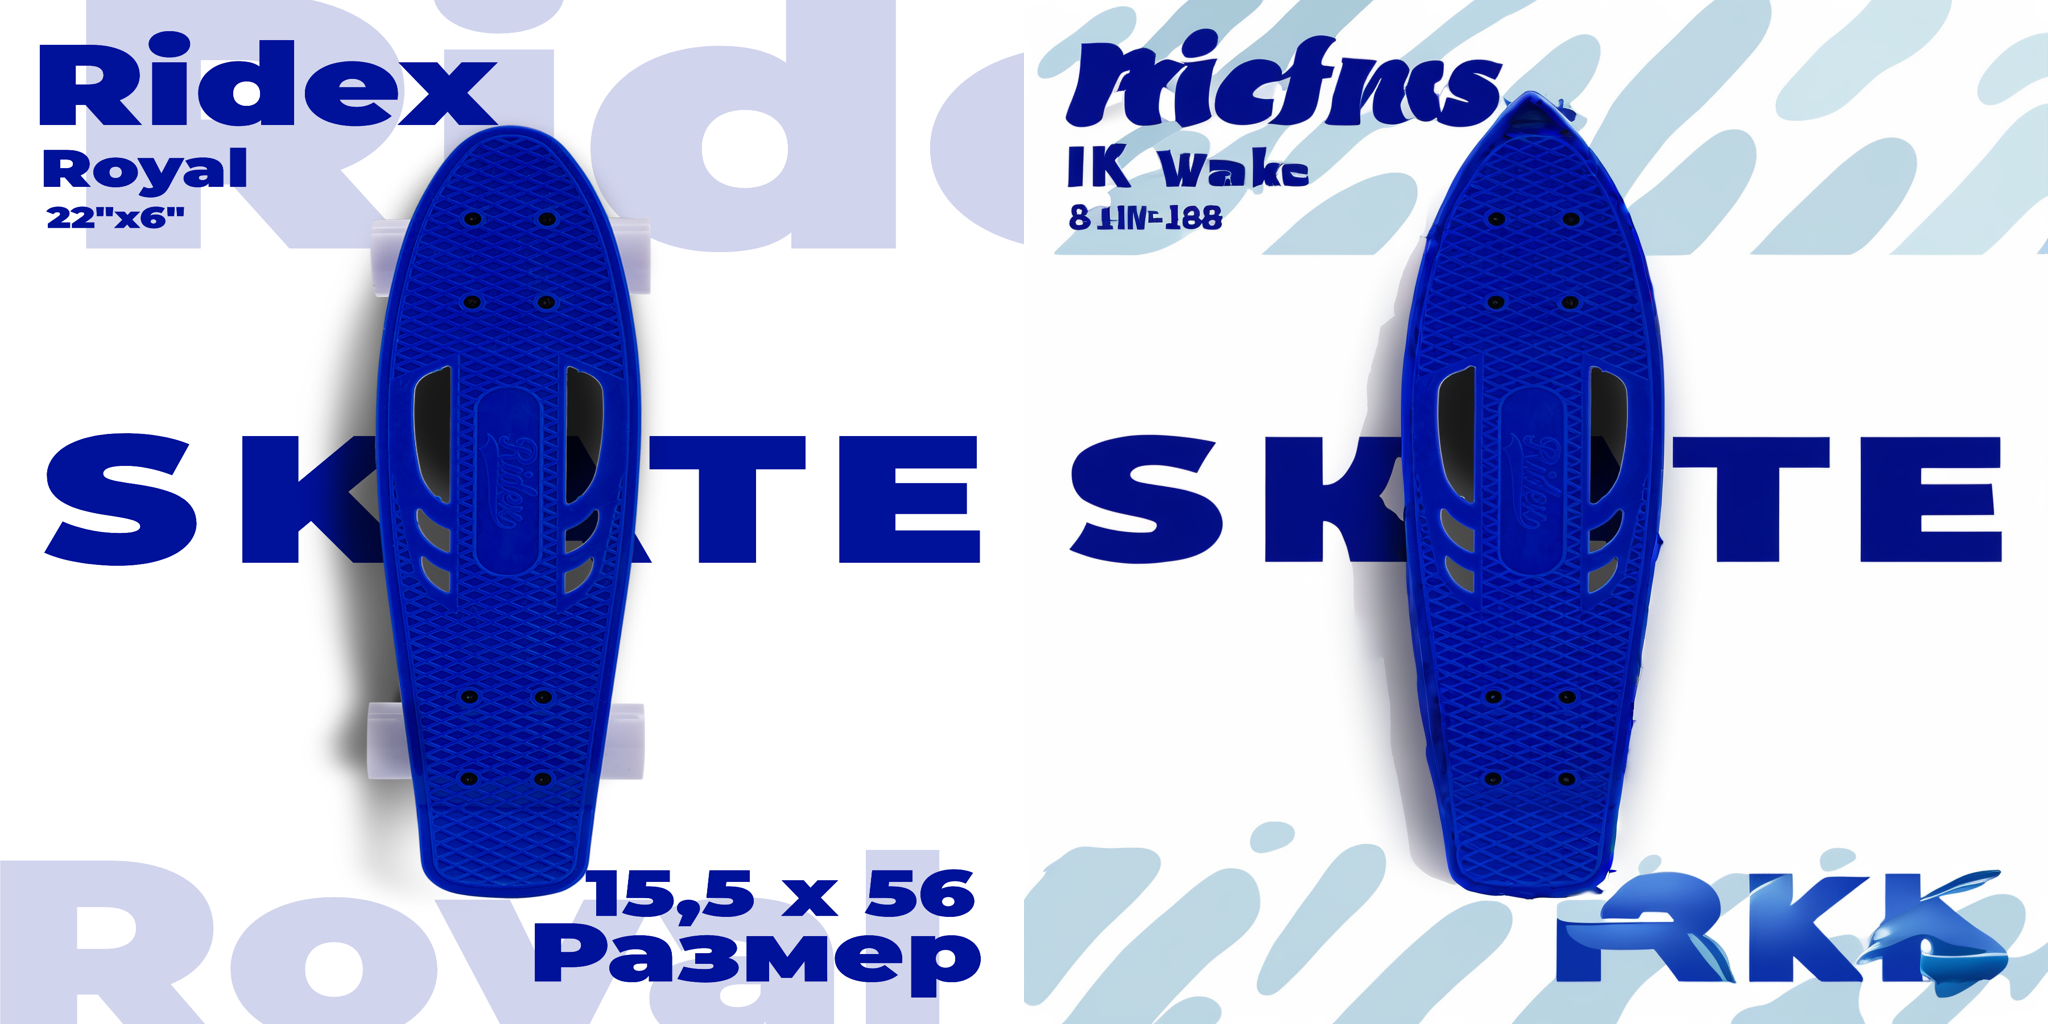

In [42]:
image.insert(0, image2sdx)

image_grid(image, 1, num_images_per_prompt + 1)

In [ ]:
image.insert(0, pil_image)

image_grid(images_sdx, 1, num_samples + 1)

In [ ]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=image,
    xyxy=high_confidence_detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in high_confidence_detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=high_confidence_detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=high_confidence_detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [47]:
from tqdm.notebook import tqdm




infographic = {1: ['other_infographics' 'good_infographics', 'bad_infographics'], 0: ['clean_photo_image_background', 'clean_photo_good_background', 'clean_photo_bad_background']}



def dino_and_sam_for_images(dino_model, sam_pred, part_dataset):
    images = {}
    annotations = {}
    urls = ["https:"+ i for i in part_dataset['pic_url'].values]
    classes_input = part_dataset['verdict'].values
    input_images = urls_to_images(urls)
    for i, img in enumerate(tqdm(input_images)):
        # print(img.mode)
        image = cv2.cvtColor(np.array(img.copy()), cv2.COLOR_BGR2RGB)

        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        detections = dino_model.predict_with_classes(
            image=image,
            classes=['all'],#enhance_class_name(class_names=CLASSES)
            box_threshold=BOX_TRESHOLD,
            text_threshold=TEXT_TRESHOLD
        )
        detections = detections[detections.class_id != None]
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        detections.mask = segment(
            sam_predictor=sam_pred,
            image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
            xyxy=detections.xyxy
        )
        images[urls[i]] = image
        annotations[urls[i]] = (detections, classes_input[i], input_images[i])
    return images, annotations

In [62]:
part_dataset = df[df['verdict']=='bad_infographics'].iloc[2000:2030, :] #100:120
#part_dataset = part_dataset.iloc[[10, 9, 12, 11], 1]

In [88]:
part_dataset

93976    //avatars.mds.yandex.net/get-marketpic/8674002...
93965    //avatars.mds.yandex.net/get-marketpic/5581373...
93991    //avatars.mds.yandex.net/get-marketpic/8332475...
93986    //avatars.mds.yandex.net/get-marketpic/1847713...
Name: pic_url, dtype: object

In [90]:
urls = ["https:"+ i for i in part_dataset.values]
urls

['https://avatars.mds.yandex.net/get-marketpic/8674002/picc5f994be2d76aed732d424752291e251/orig',
 'https://avatars.mds.yandex.net/get-marketpic/5581373/picd9a621163755cd9f53e26949f82d1470/orig',
 'https://avatars.mds.yandex.net/get-marketpic/8332475/pic5309151fa023e4a546fd1bdec4be5aed/orig',
 'https://avatars.mds.yandex.net/get-marketpic/1847713/pic8c65785b18626b796e576f1c0c9baa99/orig']

In [63]:
images, annotations = dino_and_sam_for_images(grounding_dino_model, sam_predictor, part_dataset)

  0%|          | 0/30 [00:00<?, ?it/s]

In [49]:
def area_box_calculate(box):
    return (box[2] - box[0]) * (box[3] - box[1])

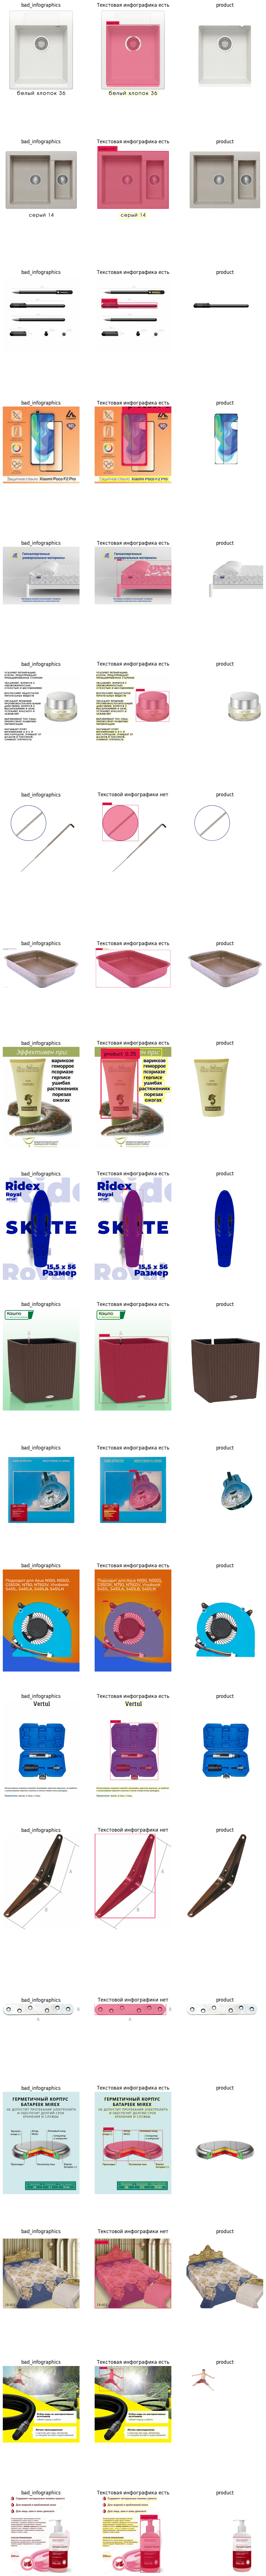

In [ ]:
from skimage import morphology
plot_images = []
plot_titles = []

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
n = 3
for image_name, (detections, cls, input_image) in annotations.items():
    title = 'Текстовой инфографики нет'
    image = images[image_name]
    plot_images.append(image)
    plot_titles.append(cls)
    if len(detections.confidence)>n:
        states = detections.confidence[np.argpartition(detections.confidence, -n)[-n:]]
        mask = np.in1d(detections.confidence, states)
        high_confidence_detections = detections[mask]
    else:
        high_confidence_detections = detections
    # print(type(image))
    bounds = reader.readtext(image.copy())

    # plt.show()
    # print(len(bounds))
    best_confidence = np.argmax(high_confidence_detections.confidence)
    # area_box_with_best_confidence = area_box_calculate(high_confidence_detections.xyxy[best_confidence, :])
    # area_box_with_not_best_confidence = area_box_calculate(high_confidence_detections.xyxy[~best_confidence, :])
    change = False

    # if abs(area_box_with_best_confidence-image.shape[0]*image.shape[1])<500:
    #     change = True

    # # if abs(bb_intersection(high_confidence_detections.xyxy[best_confidence, :], high_confidence_detections.xyxy[~best_confidence, :])-area_box_with_best_confidence)<50:
    # #     change = True
    
    # if abs(area_box_with_not_best_confidence-image.shape[0]*image.shape[1])<100:
    #     change = False
    

    
    if change:
        high_confidence_detection = high_confidence_detections[high_confidence_detections.confidence != high_confidence_detections.confidence[best_confidence]]
    else:
        high_confidence_detection = high_confidence_detections[high_confidence_detections.confidence == high_confidence_detections.confidence[best_confidence]]
    if len(bounds)>0:
        try:
            only_int_bounds_all = [(coord, text, conf) for coord, text, conf in bounds if type(coord[0][0])==np.int64] #x1, y1, x2, y2
            only_int_bounds = np.array([list(coord[0]) + list(coord[2]) for coord, text, conf in only_int_bounds_all])
            areas = (only_int_bounds[:, 2] - only_int_bounds[:, 0]) * (only_int_bounds[:, 3] - only_int_bounds[:, 1])
            intersections = np.array([bb_intersection(only_int_bounds[i, :], high_confidence_detection.xyxy[0]) for i in range(len(only_int_bounds))])
            infographic = areas - intersections > 100
            if np.sum(infographic) >= 1:
                title = 'Текстовая инфографика есть'
        except:
            if not len(high_confidence_detection)>=1:
                title = 'Инфографика есть, нет продукта'
            else:
                # print(bounds)
                # print(len(bounds))
                # print(len(infographic))
                # print(intersections)
                # print(only_int_bounds)
                # print(np.array(bounds, dtype=object)[infographic].tolist())
                title = 'Error'
            # plot_images.append(image)
    # else:

        # print('a')
        # plot_images.append(image)

    labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in high_confidence_detection]
    if len(bounds)>0:
        infogr_vis = np.array(draw_boxes(input_image, np.array(only_int_bounds_all, dtype=object)[infographic].tolist()))
        infogr_vis = cv2.cvtColor(infogr_vis, cv2.COLOR_BGR2RGB)
    else:
        infogr_vis = image.copy()

    annotated_image = mask_annotator.annotate(scene=infogr_vis, detections=high_confidence_detection)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=high_confidence_detection, labels=labels)
    plot_images.append(annotated_image)
    # print(type(annotated_image))
    try:
        best_mask = high_confidence_detection.mask[0].copy()
        b = morphology.remove_small_holes(best_mask, image.shape[0]*image.shape[1]/10)
        gray_mask = b.astype(np.uint8)
        infogr_vis[gray_mask<0.5] = [255, 255, 255]
    except:
        infogr_vis = image.copy()

    plot_images.append(infogr_vis)
    plot_titles.append(title)
    title = " ".join(set([
        CLASSES[class_id]
        for class_id
        in high_confidence_detection.class_id
    ]))
    plot_titles.append(title)

sv.plot_images_grid(
    images=plot_images,
    titles=plot_titles,
    grid_size=(len(annotations), 3),
    size=(3 * 4, len(annotations) * 6)
)

In [ ]:
plot_images = []
plot_titles = []

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
n = 2
for image_name, (detections, cls, input_image) in annotations.items():
    title = 'Инфографики нет'
    image = images[image_name]
    if len(detections.confidence)==0:
        continue
    plot_images.append(image)
    plot_titles.append(cls)
    if len(detections.confidence)>n:
        states = detections.confidence[np.argpartition(detections.confidence, -n)[-n:]]
        mask = np.in1d(detections.confidence, states)
        high_confidence_detections = detections[mask]
    else:
        high_confidence_detections = detections
    # print(type(image))
    bounds = reader.readtext(image.copy())

    # plt.show()
    # print(len(bounds))
    # if len(high_confidence_detections.confidence)>=0:
    best_confidence = np.argmax(high_confidence_detections.confidence)
    # area_box_with_best_confidence = area_box_calculate(high_confidence_detections.xyxy[best_confidence, :])
    # area_box_with_not_best_confidence = area_box_calculate(high_confidence_detections.xyxy[~best_confidence, :])
    change = False

    # if abs(area_box_with_best_confidence-image.shape[0]*image.shape[1])<500:
    #     change = True

    # # if abs(bb_intersection(high_confidence_detections.xyxy[best_confidence, :], high_confidence_detections.xyxy[~best_confidence, :])-area_box_with_best_confidence)<50:
    # #     change = True
    
    # if abs(area_box_with_not_best_confidence-image.shape[0]*image.shape[1])<100:
    #     change = False
    

    
    if change:
        high_confidence_detection = high_confidence_detections[high_confidence_detections.confidence != high_confidence_detections.confidence[best_confidence]]
    else:
        high_confidence_detection = high_confidence_detections[high_confidence_detections.confidence == high_confidence_detections.confidence[best_confidence]]
    if len(bounds)>0:
        try:
            only_int_bounds_all = [(coord, text, conf) for coord, text, conf in bounds if type(coord[0][0])==np.int64] #x1, y1, x2, y2
            only_int_bounds = np.array([list(coord[0]) + list(coord[2]) for coord, text, conf in only_int_bounds_all])
            areas = (only_int_bounds[:, 2] - only_int_bounds[:, 0]) * (only_int_bounds[:, 3] - only_int_bounds[:, 1])
            intersections = np.array([bb_intersection(only_int_bounds[i, :], high_confidence_detection.xyxy[0]) for i in range(len(only_int_bounds))])
            infographic = areas - intersections > 100
            infogr_vis = np.array(draw_boxes(input_image, np.array(only_int_bounds_all, dtype=object)[infographic].tolist()))
            # print('a')
            plot_images.append(cv2.cvtColor(infogr_vis, cv2.COLOR_BGR2RGB))
            if np.sum(infographic) >= 1:
                title = 'Инфографика есть'
        except:
            if not len(high_confidence_detection)>=1:
                title = 'Инфографика есть, нет продукта'
            else:
                # print(bounds)
                # print(len(bounds))
                # print(len(infographic))
                # print(intersections)
                # print(only_int_bounds)
                # print(np.array(bounds, dtype=object)[infographic].tolist())
                title = 'Error'
            plot_images.append(image)
    else:
        # print('a')
        plot_images.append(image)

    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _
        in high_confidence_detection]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=high_confidence_detection)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=high_confidence_detection, labels=labels)
    # print(type(annotated_image))
    plot_images.append(annotated_image)
    plot_titles.append(title)
    title = " ".join(set([
        CLASSES[class_id]
        for class_id
        in high_confidence_detection.class_id
    ]))
    plot_titles.append(title)

sv.plot_images_grid(
    images=plot_images,
    titles=plot_titles,
    grid_size=(len(annotations), 3),
    size=(3 * 4, len(annotations) * 6)
)